# Tutorial 6: Introducing `simtask`

Original authors: Joe Manning (joseph.manning{at}manchester.ac.uk) and Tom L. Underwood (tlu20{at}bath.ac.uk) 

## Introduction

The previous tutorial was rather laborious - DL_MONTE will only run one pressure point per simulation, so to calculate an isotherm, a sequence of almost identical simulations and analyes are required. 
While it's possible to run these manually, it's far easier to automate the workflows such that all you need to do is provide a simulation _template_ + a list of parameters, and a complete isotherm will fall out. 
This is the goal of the `simtask` module in the `dlmontepython` library, as described in [this paper](https://arxiv.org/abs/2104.03822).

`simtask` is set up to run DL_MONTE directly through python, by defining an _interface_ to the executable. 
You will then need to define a few simulation _observables_, which provide a pointer for the simulation postprocessing. 
Finally, you'll need to provide a set of template input files, which I've prepared for you from the previous tutorial example (located in './Tutorial_6_files'). 

### How does `simtask` work?
We now briefly describe the key features of `simtask` with the aim of elucidating how it works. The `simtask.task` module is the heart of the package. This contains the two key Python classes, `Task` and `TaskInterface`.

`Task` - This is the base class corresponding to a simulation 'task', i.e. something you want to do via simulation. E.g. in the example below the 'task' is to evaluate the energy and density via grand-canonical Monte Carlo simulation. `Task` is an abstract class in the sense that it does nothing. It is subclasses of `Task` which correspond to different possible tasks, and contain code for performing these tasks. For instance the `Measurement` class is a subclass of `Task` which calculates one or more observables at a given set of thermodynamic conditions. This is used in our example below. 

The code for `Task` subclasses for performing simulation tasks is *general*; it is not specific to a simulation program, e.g. `DL_MONTE`. This is achieved by `Task` subclasses drawing only upon functions within the `TaskInterface` class for simulation-program-specific code. These functions constitute common things one may wish to do during a task (e.g. copy input files to a new directory, run a simulation in that directory, extract the energy from the output files of a directory), common things which can be combined into complex tasks. To enable `simtask` to be used with a given simulation program, one must write a subclass of `TaskInterface` which overloads the functions in `TaskInterface` with functions which are appropriate for that simulation code. For instance, `DLMonteInterface` is the subclass of `TaskInterface` which contains functions appropriate for the simulation program `DL_MONTE`. To perform a task in conjunction with `DL_MONTE`, the relevant `Task` subclass, e.g. `Measurement`, simply 'links' to the `DLMonteInterface`, which results in `Measurement` calling the `DL_MONTE`-specific functions for the common things during its invocation.

This set-up separates the code pertaining to the task one is interested in performing from the code specific to the simulation program one will use to perform that task. `Task` subclasses will in principle work for *any* simulation program which has an existing `TaskInterface`. Conversely, simulation programs which have an existing `TaskInterface` will work for any future `Task` subclasses.


To get started, let's import all the required modules for our simulation task.

In [3]:
import dlmontepython.simtask.dlmonteinterface as interface
import dlmontepython.simtask.measurement as measurement
import dlmontepython.simtask.analysis as analysis
import dlmontepython.simtask.task as task

We now set up the relevant `TaskInterface` object, which tells the low-level machinery in `simtask` which simulation program will be used to perform the simulations, and how to perform various jobs specific to that program, e.g. extracting the energy from output files created by the program. In this case we use `DL_MONTE` to perform our simulations; thus the `TaskInterface` class we will use is `DLMonteInterface` (`DLMonteInterface` is a subclass of `TaskInterface`; see above). The code below creates a new `DLMonteInterface` object, which is linked to the relevant `DL_MONTE` executable. Later this object will be 'linked' to the relevant `Task` object before the task is performed.

Note that the `DLMonteInterface` object must be provided the location and name of the `DL_MONTE` executable on your local system. In the example below 'DL_MONTE-SRL.X' is used as a placeholder; you must alter that string in the code below to reflect your local system.

In [4]:
# The line below creates a DL_MONTE-specific interface. Note that the interface 
# must know the location of the DL_MONTE executable - which is specified as the 
# argument to the DLMonteInterface constructor.
# You will have to adapt the location of the executable to suit your local system.

interface = interface.DLMonteInterface("DLMONTE-SRL.X")

## Defining `Observable`s

Set up a list of 'observables' to track and analyse. 
Observables must be `Observable` objects, and the nature of `Observable` objects may vary between simulation codes. For DL_MONTE, only observables corresponding to variables output periodically in YAMLDATA are currently supported. 
For a variable 'foo' specified in the YAMLDATA file the corresponding `Observable` object is returned by the command `task.Observable( ("foo",) )`. 
**Note the essential comma after "foo"!** 

For a variable in YAMLDATA which is an array (e.g., 'nmol'), the observable corresponding to the nth element in the array is returned by the command `task.Observable( ("foo",n-1) )`. 
See below: `energy_obs` corresponds to the 'energy' variable in YAMLDATA, and `nmol_obs` corresponds to the 2nd element in the 'nmol' array in YAMLDATA (which in fact is the number of molecules belonging to the 1st molecular species).

In [5]:
energy_obs = task.Observable( ("energy",) )
nmol_obs = task.Observable( ("nmol",1) )
observables = [ energy_obs, nmol_obs ]

### Termination criteria

The `Measurement` class will perform back-to-back simulations until one of a number of customisable criteria have been met. The criteria are determined by the arguments passed to the constructor of the `Measurement` object. For now we apply two criteria. The first is that the energy is evaluated to a precision of 0.2 (energy units), i.e. the back-to-back simulations are terminated if the statistical uncertainty in the energy is less than this precision. The second criterion is that the number of back-to-back simulations does not exceed 20. The below code creates a `Measurement` object with the aforementioned criteria. Moreover we set the name of the directory in which the simulations are to be performed as `fixedprecision`.

In [6]:
precisions = { energy_obs : 0.2 }

## Defining a `Measurement`
Set up the relevant Measurement object - which will actually perform the simulations and data analysis.
Note that all the simulations and output files pertaining to analysis will be created in the directory'fixedprecision' (via the 'outputdir' argument), and that we will impose a threshold precision on the energy as implied by the dictionary 'precisions' described above. Furthermore, we specify that no more than 20 simulations will ever be performed (via the 'maxsims' argument)

In [7]:
m = measurement.Measurement(interface, observables, maxsims=20, precisions=precisions, outputdir='./fixedprecision')

### Running the task

As mentioned above, the task is invoked via the command

```python
m.run()
```

#### Troubleshooting

If you encounter a problem with running the next block of code, one possible reason is that the path to the `DL_MONTE` executable used to initialise the `DLMonteInterface` object above does not exist, or is wrong.

Also, you may encounter issues running this next cell on windows, so I've provided a python script for you to run the same simulation on Linux as required and continue on below.

In [ ]:
import os
import shutil
from time import sleep

os.chdir('./Tutorial_6_files/')
if os.path.exists('fixedprecision'):
    shutil.rmtree('fixedprecision')

sleep(5)
m.run()

## Data postprocessing and analysis
Once the task is complete in the 'fixedprecision' directory there will be directories 'sim_1', 'sim_2', etc. containing the input and output files corresponding to each simulation. 
Note that 'sim_2' is a resumption of 'sim_1', 'sim_3' is a resumption of 'sim_2', etc. Furthermore the files 'energy_converge.dat' and 'nmol_0_converge.dat' contain, respectively, the mean and uncertainty in the energy and number of molecules after each simulation. 
Note that the uncertainty decreases as expected after each simulation. 
Note also that no more simulations were performed once the uncertainty in the energy was determined to within 0.2 (units of energy).

Just like we did in the last few tutorials, let's visualize that with `pandas`!

Text(0, 0.5, 'Molecules adsorbed (n/uc)')

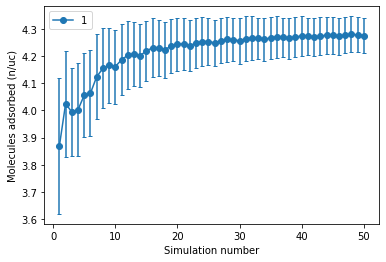

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

thing = pd.read_table('./Tutorial_6_files/fixedprecision/nmol_1_converge.dat', header=None, sep=' ')
pd.DataFrame(thing).plot(x=0,y=1, yerr=2, capsize=2, marker='o')
plt.xlabel('Simulation number')
plt.ylabel('Molecules adsorbed (n/uc)')

Text(0, 0.5, 'Energy (kCal/mol)')

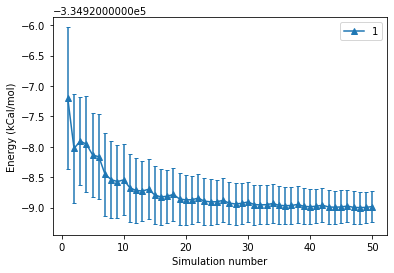

In [31]:
thing = pd.read_table('./Tutorial_6_files/fixedprecision/energy_converge.dat', header=None, sep=' ')
pd.DataFrame(thing).plot(x=0,y=1, yerr=2, capsize=2, marker='^')
plt.xlabel('Simulation number')
plt.ylabel('Energy (kCal/mol)')

From these data you can see that the number of particles equilibrates very quickly, but the simulaiton didn't stop. It looks like the energy didn't converge close enough to complete! 

### Challenge 1: How can you get the simulations to stop once the number of molecules have converged? 
Hint: try switching the precisions to 'nmols' or upping the maximun number of simulations. Did these help?

Text(0, 0.5, 'Molecules adsorbed (n/uc)')

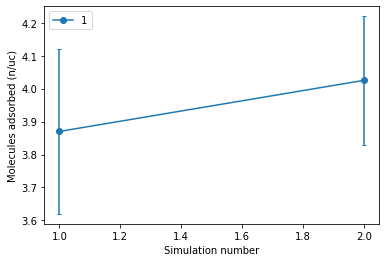

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

thing = pd.read_table('./Tutorial_6_files/fixedprecision/nmol_1_converge.dat', header=None, sep=' ')
pd.DataFrame(thing).plot(x=0,y=1, yerr=2, capsize=2, marker='o')
plt.xlabel('Simulation number')
plt.ylabel('Molecules adsorbed (n/uc)')

Text(0, 0.5, 'Energy (kCal/mol)')

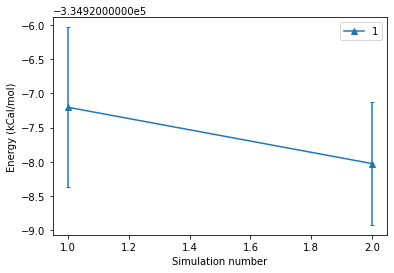

In [33]:
thing = pd.read_table('./Tutorial_6_files/fixedprecision/energy_converge.dat', header=None, sep=' ')
pd.DataFrame(thing).plot(x=0,y=1, yerr=2, capsize=2, marker='^')
plt.xlabel('Simulation number')
plt.ylabel('Energy (kCal/mol)')